In [1]:
import numpy as np
import copy
from PIL import Image
import open3d as o3d
import matplotlib.pyplot as plt
from magpie.perception import pcd
from open3d.web_visualizer import draw

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
import importlib
importlib.reload(pcd)

<module 'magpie.perception.pcd' from '/home/will/MAGPIE/magpie/perception/pcd.py'>

In [3]:
from magpie import realsense_wrapper as real
rsc = real.RealSense()
rsc.initConnection()

In [4]:
from magpie.perception.label_owlvit import LabelOWLViT
path = "google/owlvit-base-patch32"
label_vit = LabelOWLViT(path)

In [7]:
from magpie.perception.mask_sam import MaskSAM
ckpt = "/home/will/workspace/owlvit_segment_anything/sam_vit_h_4b8939.pth"
mask_sam = MaskSAM(ckpt)

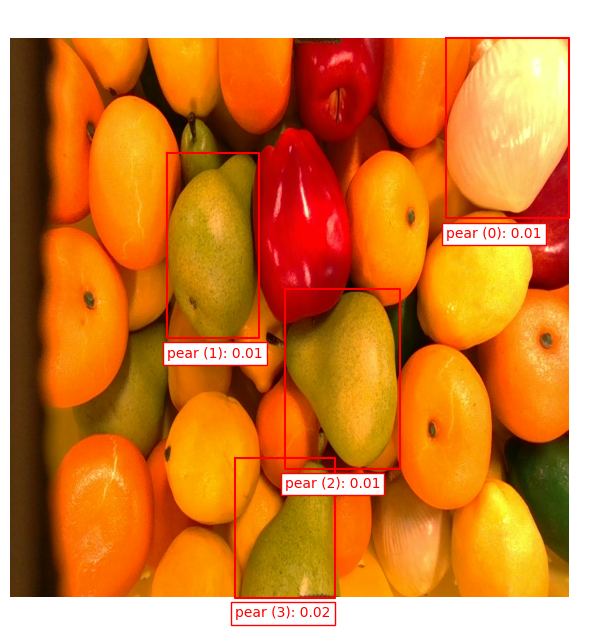

In [18]:
p, rgbd_image = rsc.getPCD()
image = np.array(rgbd_image.color)
queries = ["a photo of an apple", "a photo of a lemon", "a photo of a lime", "a photo of a pear", "a photo of a onion"]
queries = ["a photo of a pear"]
abbrevq = ["apple", "lemon", "lime", "pear", "onion"]
abbrevq = ["pear"]
label_vit.set_threshold(0.01)
bboxes, uboxes = label_vit.label(image, queries, abbrevq, plot=True)


In [15]:
index = 3
# this does the [x, y, z] --> [y, -x, z] grasp pose switch, and the -y inversio on the y-axis orientation
rgbd_image, cpcd, tmat = pcd.get_segment(label_vit.boxes, index, rgbd_image, rsc, type="box", display=False)
tmat, tmat[:3, 3]

modified indices: [0 1 2]
z-axis dot product: [0.90622122]
tmat: [[-0.42293845  0.88162209  0.20944103 -0.05415592]
 [-0.86962551 -0.32993016 -0.36728403 -0.0310177 ]
 [-0.2547048  -0.33747381  0.90622122  0.20840183]
 [ 0.          0.          0.          1.        ]]
scaled tmat: [[-0.27592878  0.35546885  0.04685422 -0.05415592]
 [-0.56735137 -0.1330274  -0.0821654  -0.0310177 ]
 [-0.16617166 -0.13606899  0.20273147  0.20840183]
 [ 0.          0.          0.          1.        ]]
TriangleMesh with 1134 points and 2240 triangles.


(array([[-0.42293845,  0.88162209,  0.20944103, -0.0310177 ],
        [-0.86962551, -0.32993016, -0.36728403,  0.05415592],
        [-0.2547048 , -0.33747381,  0.90622122,  0.20840183],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([-0.0310177 ,  0.05415592,  0.20840183]))

[000:000][5386] (stun_port.cc:96): Binding request timed out from 192.168.0.x:60986 (enp3s0)


In [19]:
# Segmentation Masks
mask_sam.set_image_and_labels(np.array(rgbd_image.color), np.array([np.array(i[0]) for i in label_vit.boxes]), label_vit.labels)


(-0.5, 1279.5, 719.5, -0.5)

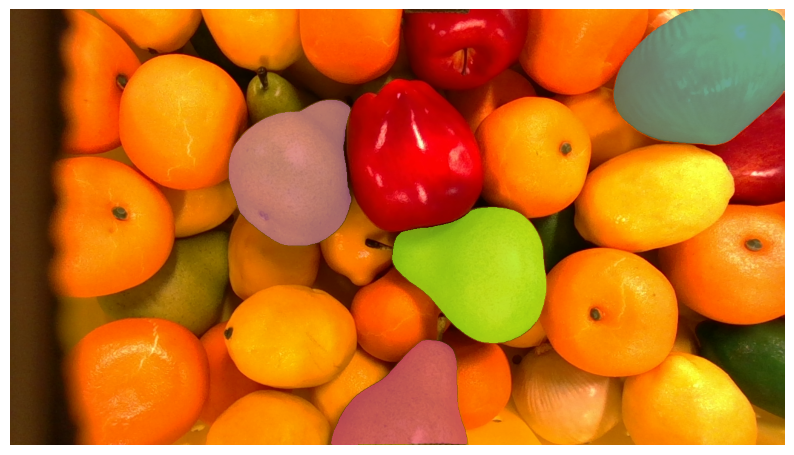

In [20]:
masks = mask_sam.get_masks(label_vit.labels)
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    mask_sam.show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
plt.axis('off')

In [21]:
index = 2
rgbd_image, mcpcd, tmat = pcd.get_segment(masks, index, rgbd_image, rsc, type="mask", viz_scale=2500.0, display=True)

modified indices: [2 1 1]
modified indices: [2 0 1]
z-axis dot product: [0.88494469]
tmat: [[ 0.8628242  -0.457867    0.21422467  0.04744934]
 [ 0.50478283  0.75776883 -0.41349812  0.02643014]
 [ 0.02699436  0.46491312  0.88494469  0.20752492]
 [ 0.          0.          0.          1.        ]]
scaled tmat: [[ 0.44246707 -0.02454679  0.17253604  0.04744934]
 [ 0.25885896  0.04062488 -0.3330304   0.02643014]
 [ 0.01384305  0.02492454  0.71273235  0.20752492]
 [ 0.          0.          0.          1.        ]]
TriangleMesh with 1134 points and 2240 triangles.
[Open3D INFO] Window window_1 created.


WebVisualizer(window_uid='window_1')

[Open3D INFO] Sending init frames to window_1.


In [22]:
tmat, tmat[:3, 3]

(array([[ 0.8628242 , -0.457867  ,  0.21422467,  0.02643014],
        [ 0.50478283,  0.75776883, -0.41349812, -0.04744934],
        [ 0.02699436,  0.46491312,  0.88494469,  0.20752492],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([ 0.02643014, -0.04744934,  0.20752492]))

[4347:398][5386] (stun_port.cc:96): Binding request timed out from 192.168.0.x:37111 (enp3s0)


array([-0.08828127, -0.08545051,  0.22066256])